In [9]:
import collections
import numpy as np
import scipy.optimize

tax_rates = [
    (9700, 0.10),
    (39475, 0.12),
    (84200, 0.22),
    (160725, 0.24),
    (204100, 0.32),
    (510300, 0.35),
    (1000^5, 0.37)
]

def posttax(pretax_income_arg, quiet=True):
    if isinstance(pretax_income_arg, collections.Iterable):
        return [posttax(i) for i in pretax_income_arg]
    tax_owed = 0
    previous_end = 0
    pretax_income = pretax_income_arg - 12200 # Standard Exemption
    for end, rate in tax_rates:
        money_in_bracket = max(min(pretax_income - previous_end, end - previous_end),0)
        tax_owed = tax_owed + money_in_bracket * rate
        if not quiet: print('Money in bracket is {}, adding {} to the new tax total of {}'.format(money_in_bracket, money_in_bracket * rate, tax_owed))
        previous_end = end
    return round(pretax_income_arg - tax_owed,1)

def pretax(posttax_income, quiet=True):
    if isinstance(posttax_income, collections.Iterable):
        return [pretax(i) for i in posttax_income]
    pretax_error = lambda pretax_income : posttax(pretax_income) - posttax_income
    # Use a Brent gradient approach method of solving roots to determine the proper value
    pretax_income = scipy.optimize.brentq(pretax_error, 0, posttax_income * 100)
    if not quiet: print('Solved for a pretax_income of {} on a posttax_income of {}'.format(pretax_income, posttax_income))
    return round(pretax_income,1)

    

In [10]:
print('{}'.format(pretax(100000)))

120061.2


Pretax Income ranging from 0 to 340000


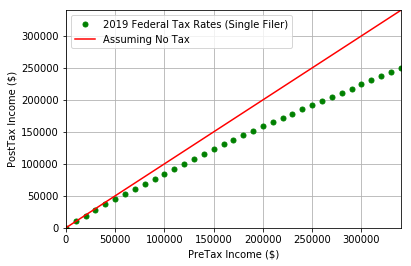

In [11]:
import matplotlib.pyplot as plt

pretax_income = np.arange(0, 350 * 1000, 10 * 1000)
posttax_income = posttax(pretax_income)

print('Pretax Income ranging from {} to {}'.format(pretax_income[0], pretax_income[-1]))

fig, ax = plt.subplots()
plt.plot(pretax_income, posttax_income, 'og', ms=5, label='2019 Federal Tax Rates (Single Filer)')
plt.plot(pretax_income, pretax_income, '-r', ms=4, label='Assuming No Tax')
plt.axis([0,pretax_income[-1],0,pretax_income[-1]])
plt.legend()
ax.set_xlabel('PreTax Income ($)')
ax.set_ylabel('PostTax Income ($)')
plt.grid()

plt.show()


Pretax Income ranging from 75000 to 345000
Avg approx error is 0.0038
Polynomial terms are [-4.94625324e-07  8.94925918e-01]


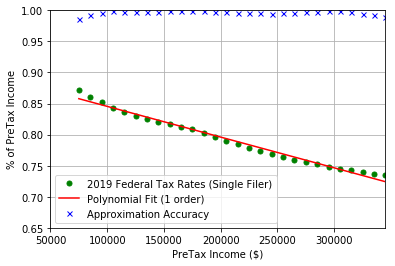

In [12]:
pretax_income = np.arange(75 * 1000, 350 * 1000, 10 * 1000)
posttax_income = posttax(pretax_income)
posttax_income_as_percent = posttax_income/pretax_income
polyfit_order = 1
approx_percent_polynom = np.poly1d(np.polyfit(pretax_income, posttax_income/pretax_income, polyfit_order))
approx_percent = approx_percent_polynom(pretax_income)
approximation_error = [abs(x-y) for x, y  in zip(approx_percent, posttax_income_as_percent)]
avg_approx_error = np.average(approximation_error)
approximation_accuracy = [1-x for x in approximation_error]

print('Pretax Income ranging from {} to {}'.format(pretax_income[0], pretax_income[-1]))
print('Avg approx error is {:.2}'.format(avg_approx_error))
print('Polynomial terms are {}'.format(np.asarray(approx_percent_polynom)))

fig, ax = plt.subplots()
plt.plot(pretax_income, posttax_income_as_percent, 'og', ms=5, label='2019 Federal Tax Rates (Single Filer)')
plt.plot(pretax_income, approx_percent, '-r', ms=5, label='Polynomial Fit ({} order)'.format(polyfit_order))
plt.plot(pretax_income, approximation_accuracy, 'xb', ms=5, label='Approximation Accuracy')
plt.axis([50000,pretax_income[-1],0.65,1])
plt.legend()
ax.set_xlabel('PreTax Income ($)')
ax.set_ylabel('% of PreTax Income')
plt.grid()
plt.show()


My financial modeling is often done in very gross terms. Lately, I've been considering annual expenditure models, and how they might allow me to make higher income now, and lower income later, and still meet/achieve primary life objectives.

These objectives include:
* Primary Residence
 * Often assumed to be on the order of a \\$400,000 structure, at \\$3000 per month
* Secondary Residence
 * Often assumed to be on the order of a \\$200,000 property, at \\$1500 per month
* Vehicle Costs
 * Assume \\$700 per month
* Direct "Retirement" Savings
 * Assume $50k/annum for \\$4166 per month
* Monthly 'Spend' (including Utilities, Credit Cards, Fuel, etc)
 * Currently at ~\\$3000 per month
* "Other" (Ren Faire, Solar, Travel, Computers, etc)
 * Proposing ~\\$1000 per month

All told, this is a monthly spend of nearly 13366, or annually \\$160392, which would require about \\$202653 of income. Honestly quite achievable in the bay, but tougher to come by elsewhere. 

Once/if I get to a Fire-launch-position, I won't need to save nearly as much. That could drop my savings-requirements to only ... say... 19k+6k = 25k. That's a 25k post-tax savings... so I'd need 135k post-tax or about $166k. Almost sane, and that's still saving quite a bit (25k/annum)

In [13]:
primary_structure_value = 400000
primary_structure_yearly = primary_structure_value/9 # approximation based on earlier work, for a 15 year mortgage
primary_structure_monthly = primary_structure_yearly / 12
print('For a structure of {}, we approximate a monthly cost of {:2}'.format(primary_structure_value, round(primary_structure_monthly)))
monthly_spend = 3000 + 1500 + 700 + 4166 + 3000 + 1000
print(monthly_spend)
annual_spend = 12 * monthly_spend
print(annual_spend)
pretax_annual = pretax(annual_spend)
print(pretax_annual)

print(pretax(135000))

For a structure of 400000, we approximate a monthly cost of 3704
13366
160392
202653.6
166113.8


In [14]:
import sys
class RecurringCashflow:
    def define_monthly(self, monthly_outflow, name, monthly_nw=0, yearly_apr=1.0, year_start=0, year_end=sys.maxsize):
        self.monthly_outflow = monthly_outflow
        self.annual_outflow = monthly_outflow * 12
        self.name = name
        self.monthly_nw = monthly_nw
        self.yearly_nw = monthly_nw * 12
        self.yearly_apr = yearly_apr
        self.year_start = year_start
        self.year_end = year_end
        return self
        
    def define_yearly(self, yearly_outflow, name, yearly_nw=0, yearly_apr=1.0, year_start=0, year_end=sys.maxsize):
        self.monthly_outflow = round(yearly_outflow / 12.0, 1)
        self.annual_outflow = yearly_outflow
        self.name = name
        self.monthly_nw = round(yearly_nw / 12.0, 1)
        self.yearly_nw = yearly_nw
        self.yearly_apr = yearly_apr
        self.year_start = year_start
        self.year_end = year_end
        return self
    
    def yearly_cashflow(self, year):
        if year >= self.year_start and year <= self.year_end:
            years_accumulated = year - self.year_start
            return abs(self.annual_outflow * (self.yearly_apr**years_accumulated))
        else:
            return 0
    
    def yearly_nwflow(self, year):
        if year >= self.year_start and year <= self.year_end:
            years_accumulated = year - self.year_start
            return abs(self.yearly_nw * (self.yearly_apr**years_accumulated))
        else:
            return 0

        
class CashflowModel():
    def __init__(self, name='Unnamed'):
        self.cashflows = []
        self.name = name
        
    def add_RecurringCashflow(self, recurring_cashflow):
        self.cashflows.append(recurring_cashflow)
        
    def add_MonthlyCashflow(self, *args, **kwargs):
        rc = RecurringCashflow().define_monthly(*args, **kwargs)
        self.add_RecurringCashflow(rc)
        
    def add_YearlyCashflow(self, *args, **kwargs):
        rc = RecurringCashflow().define_yearly(*args, **kwargs)
        self.add_RecurringCashflow(rc)
        
    def get_annual_cashflow(self, year):
        return sum([x.yearly_cashflow(year) for x in self.cashflows])
    
    def get_annual_nwflow(self, year):
        return sum([x.yearly_nwflow(year) for x in self.cashflows])
    
    def plot_annual_flows(self, year=0):
        fig = plt.figure(figsize=(14,4))
        plt.suptitle('Annual Cashflows for $\it{}$'.format(self.name))
        plt.subplot(1,2,1)
        plt.pie([x.yearly_cashflow(year) for x in self.cashflows], labels=[x.name for x in self.cashflows])
        plt.title('Annual Cashflows ($'+str(sum([x.yearly_cashflow(year) for x in self.cashflows]))+')')
        plt.subplot(1,2,2)
        plt.pie([abs(x.yearly_nwflow(year)) for x in self.cashflows], labels=[x.name +' ($'+ str(int(x.yearly_nwflow(year))) + ')' if x.yearly_nw != 0 else '' for x in self.cashflows])
        plt.title('Yearly NW Flow ($'+str(sum([x.yearly_nwflow(year) for x in self.cashflows]))+')')
        plt.show()
        
    def plot_monthly_flows(self, year=0):
        fig = plt.figure(figsize=(14,4))
        plt.suptitle('Monthly Cashflows for $\it{}$'.format(self.name))
        plt.subplot(1,2,1)
        plt.pie([x.yearly_cashflow(year)/12 for x in self.cashflows], labels=[x.name for x in self.cashflows])
        monthly_cashflow_sum = sum([x.yearly_cashflow(year)/12 for x in self.cashflows])
        plt.title('Monthly Cashflows (${})'.format(int(monthly_cashflow_sum)))
        plt.subplot(1,2,2)
        monthly_nwflow_list = [round(abs(x.yearly_nwflow(year))/12) for x in self.cashflows]
        monthly_nwflow_labels = [x.name + '(${})'.format(y) if y != 0 else '' for x,y in zip(self.cashflows,monthly_nwflow_list)]
        plt.pie(monthly_nwflow_list, labels=monthly_nwflow_labels)
        plt.title('Monthly NW Flow (${})'.format(sum(monthly_nwflow_list)))
        plt.show()


ho_model = CashflowModel('Home Ownership BS/NBR') #Home Ownership Model (as compared to renting, etc)
ho_model.add_MonthlyCashflow(-4000, 'Primary Residence', monthly_nw=2000)
ho_model.add_MonthlyCashflow(-2000, 'Secondary Residence', monthly_nw=1000)
ho_model.add_MonthlyCashflow(-800, 'Auto Costs')
ho_model.add_YearlyCashflow(-19000, '401k Savings', yearly_nw=19000)
ho_model.add_YearlyCashflow(-5000, 'IRA Savings', yearly_nw=5000)
ho_model.add_YearlyCashflow(-26000, 'Brokerage Savings', yearly_nw=26000)
ho_model.add_MonthlyCashflow(-3000, 'Monthly Spend')
ho_model.add_YearlyCashflow(-12000, 'Yearly Spend')
#ho_model.plot_annual_flows()
#ho_model.plot_monthly_flows()

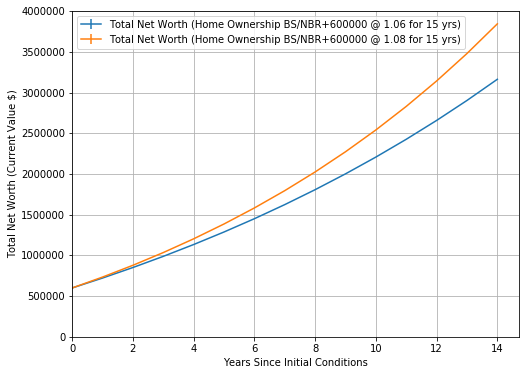

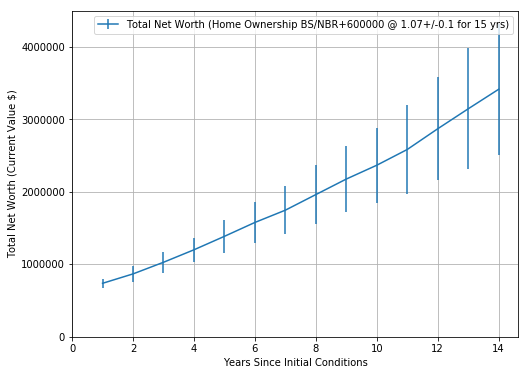

NameError: name 'hodflist' is not defined

In [18]:
import pandas as pd
import copy

# We create a list of dictionaries, where each entry/dict is one row

class FinancialModel:
    # A Financial Model takes in initial conditions and a CashflowModel, creating a time history of key metrics:
    # Total Net Worth, Annual Outflows, Annual NW Increase, Annual Pretax Required, and Year ID
    # These are returned in a dataframe by 'sim', then passed to plotting/analysis/stored
    
    def sim(self, cashflowmodel, nyears=30, initial_nw=0, nw_apr=1.07):
        year_dict = {}
        year_dict['Total Net Worth'] = initial_nw
        year_dict['Annual Outflows'] = 0
        year_dict['Annual NW Increase'] = 0
        year_dict['Annual Pretax Required'] = pretax(year_dict['Annual Outflows'])
        year_dict['nw_apr'] = nw_apr
        year_dict['Year ID'] = 0
        years = []
        years.append(copy.deepcopy(year_dict))
        last_year = copy.deepcopy(year_dict)
        for current_year_id in np.arange(1,nyears):
            # Each year, we increase our networth by some percentage due to asset appreciation
            # We do not (yet) modify or alter our outflows, annual nw increase, or pretax required
            year_dict['Annual NW Increase'] = cashflowmodel.get_annual_nwflow(current_year_id) #sum([x.yearly_nwflow(current_year_id) for x in cashflows])
            year_dict['Total Net Worth'] = round(last_year['Total Net Worth'] * nw_apr + year_dict['Annual NW Increase'],0)
            year_dict['Annual Outflows'] = cashflowmodel.get_annual_cashflow(current_year_id) #sum([x.yearly_cashflow(current_year_id) for x in cashflows])
            year_dict['Annual Pretax Required'] = pretax(year_dict['Annual Outflows'])
            year_dict['nw_apr'] = nw_apr
            year_dict['Year ID'] = current_year_id
            #print('In year {}, NW is {:,}'.format(current_year_id, int(year_dict['Total Net Worth'])))
            last_year = copy.deepcopy(year_dict)
            years.append(last_year)
        df_summary = {}
        df_summary['name'] = ('{}+{} @ {} for {} yrs'.format(cashflowmodel.name, initial_nw, nw_apr, nyears))
        df_summary['nyears'] = nyears
        df_summary['initial_nw'] = initial_nw
        df_summary['nw_apr'] = nw_apr
        return (pd.DataFrame(years), df_summary)
    
    def sim_with_variable_apr(self, cashflowmodel, nyears=30, initial_nw=0, nw_apr_avg=1.07, nw_apr_stdev=1.07*0.50):
        sim_run_dfs = []
        for run in np.arange(0,100): # should use >= 100 runs for some statistical interest
            year_dict = {}
            year_dict['Total Net Worth'] = initial_nw
            year_dict['Annual Outflows'] = 0
            year_dict['Annual NW Increase'] = 0
            year_dict['Annual Pretax Required'] = pretax(year_dict['Annual Outflows'])
            year_dict['nw_apr'] = nw_apr_avg
            year_dict['Year ID'] = 0
            year_dict['Sim Run'] = run
            years = []
            years.append(copy.deepcopy(year_dict))
            last_year = copy.deepcopy(year_dict)
            for current_year_id in np.arange(1,nyears):
                # Each year, we increase our networth by some percentage due to asset appreciation
                # We do not (yet) modify or alter our outflows, annual nw increase, or pretax required
                nw_apr = np.random.normal(loc = nw_apr_avg, scale = nw_apr_stdev, size = 1)[0]
                year_dict['Annual NW Increase'] = cashflowmodel.get_annual_nwflow(current_year_id) #sum([x.yearly_nwflow(current_year_id) for x in cashflows])
                year_dict['Total Net Worth'] = round(last_year['Total Net Worth'] * nw_apr + year_dict['Annual NW Increase'],0)
                year_dict['Annual Outflows'] = cashflowmodel.get_annual_cashflow(current_year_id) #sum([x.yearly_cashflow(current_year_id) for x in cashflows])
                year_dict['Annual Pretax Required'] = pretax(year_dict['Annual Outflows'])
                year_dict['nw_apr'] = nw_apr
                year_dict['Year ID'] = current_year_id
                #print('In year {}, NW is {:,}'.format(current_year_id, int(year_dict['Total Net Worth'])))
                last_year = copy.deepcopy(year_dict)
                years.append(last_year)
            sim_run_dfs.append(pd.DataFrame(years))
        # We now have a fairly large list of DataFrames to process... (roughly 100 at last count)
        all_dfs = pd.concat(sim_run_dfs)
        year_summary = {}
        years = []
        for current_year_id in np.arange(1, nyears):
            this_years_rows = [df.loc[df['Year ID'] == current_year_id] for df in sim_run_dfs]
            this_years_rows = pd.concat(this_years_rows)
            year_summary['Annual NW Increase'] = np.mean(this_years_rows['Annual NW Increase'].tolist())
            year_summary['Annual NW Increase:STDEV'] = np.std(this_years_rows['Annual NW Increase'])
            year_summary['Total Net Worth'] = np.mean(this_years_rows['Total Net Worth'])
            year_summary['Total Net Worth:STDEV'] = np.std(this_years_rows['Total Net Worth'])
            year_summary['Annual Outflows'] = np.mean(this_years_rows['Annual Outflows'])
            year_summary['Annual Outflows:STDEV'] = np.std(this_years_rows['Annual Outflows'])
            year_summary['Annual Pretax Required'] = np.mean(this_years_rows['Annual Pretax Required'])
            year_summary['Annual Pretax Required:STDEV'] = np.std(this_years_rows['Annual Pretax Required'])
            year_summary['nw_apr'] = np.mean(this_years_rows['nw_apr'])
            year_summary['nw_apr:STDEV'] = np.std(this_years_rows['nw_apr'])
            year_summary['Year ID'] = np.mean(this_years_rows['Year ID'])
            year_summary['Year ID:STDEV'] = np.std(this_years_rows['Year ID'])
            this_year = copy.deepcopy(year_summary)
            years.append(this_year)
        df_summary = {}
        df_summary['name'] = ('{}+{} @ {}+/-{} for {} yrs'.format(cashflowmodel.name, initial_nw, nw_apr_avg, nw_apr_stdev, nyears))
        df_summary['nyears'] = nyears
        df_summary['initial_nw'] = initial_nw
        df_summary['nw_apr'] = nw_apr_avg
        df_summary['nw_apr_stdev'] = nw_apr_stdev
        return (pd.DataFrame(years), df_summary)
    
    def plot(self, df_tuple):
        fig = plt.figure(figsize=(8,6))
        plt.subplot(1,1,1)
        ax = plt.gca()
        if isinstance(df_tuple, list):
            df_tuple_list = df_tuple
        else:
            df_tuple_list = [df_tuple]
        for df, df_summary in df_tuple_list:
            error_bars = df['Total Net Worth:STDEV'] if 'Total Net Worth:STDEV' in df.columns else 0
            plt.errorbar(df['Year ID'], df['Total Net Worth'], yerr=error_bars, ms=5, label='Total Net Worth ({})'.format(df_summary['name']))
        plt.legend()
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)
        ax.set_xlabel('Years Since Initial Conditions')
        ax.set_ylabel('Total Net Worth (Current Value $)')
        plt.grid()
        plt.show()

cur_state = FinancialModel()
ho_df_tuple = cur_state.sim(ho_model, nyears=15, initial_nw=600000, nw_apr=1.06)
ho_df_tuple2 = cur_state.sim(ho_model, nyears=15, initial_nw=600000, nw_apr=1.08)

cur_state.plot([ho_df_tuple, ho_df_tuple2])

results = cur_state.sim_with_variable_apr(ho_model, nyears=15, initial_nw=600000, nw_apr_avg=1.07, nw_apr_stdev=0.10)
cur_state.plot([results])

is_list = isinstance(hodflist, list)


